In [ ]:
!pip install plot_keras_history

In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install keras==2.3.1

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pandas as pd
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from plot_keras_history import plot_history


Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

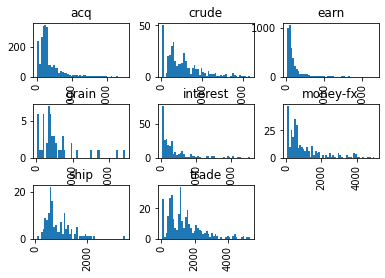

<Figure size 432x288 with 0 Axes>

In [ ]:
#Data Preparation
import pandas as pd
news=pd.read_table('drive/My Drive/Colab Data/r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()
a = news.groupby("Class")
a.head()
a.describe()
y=news['Class']
X=news['Text']

##check the length to determine the document length for DNN

length=news['Text'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
news.hist(column='Length',by='Class',bins=50)

plt.figure()

In [ ]:
#Data Preprocessing 

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#fixed length for improved efficiency
MAX_LEN=100 
maxlen=MAX_LEN

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="drive/My Drive/Colab Data/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 19998
max length text: 964
0.848034803480348


In [ ]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

(2303, 8)

In [ ]:
#Define the BiLSTM model with output Dropout
##############################################
model_out_dp = Sequential()
model_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False)) # freeze the emdedding layer since it is from glove
model_out_dp.add(Bidirectional(LSTM(64)))  # hidden size
#output Dropout, defined after the LSTM layer
model_out_dp.add(Dropout(0.5))
model_out_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_out_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_out_dp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/15
5371/5371 [==============================] - 17s 3ms/step - loss: 1.0608 - accuracy: 0.6395 - val_loss: 0.5591 - val_accuracy: 0.7946
Epoch 2/15
5371/5371 [==============================] - 16s 3ms/step - loss: 0.5598 - accuracy: 0.8131 - val_loss: 0.5219 - val_accuracy: 0.8289
Epoch 3/15
5371/5371 [==============================] - 16s 3ms/step - loss: 0.4525 - accuracy: 0.8546 - val_loss: 0.4217 - val_accuracy: 0.8498
Epoch 4/15
5371/5371 [==============================] - 16s 3ms/step - loss: 0.3759 - accuracy: 0.8756 - val_loss: 0.3230 - val_accuracy: 0.8871
Epoch 5/15
5371/5371 [==============================] - 16s 3ms/step - loss: 0.3169 - accuracy: 0.8939 - val_loss: 0.2990 - val_accuracy: 0.8984
Epoch 6/15
5371/5371 [==============================] - 16s 3ms/step - loss: 0.2885 - accuracy: 0.9101 - val_loss: 0.2712 - val_accuracy: 0.9084
Epoch 7/15
5371/5371 [==============================] - 16s 3ms/step - lo

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f445bc0e690>,
       dtype=object))

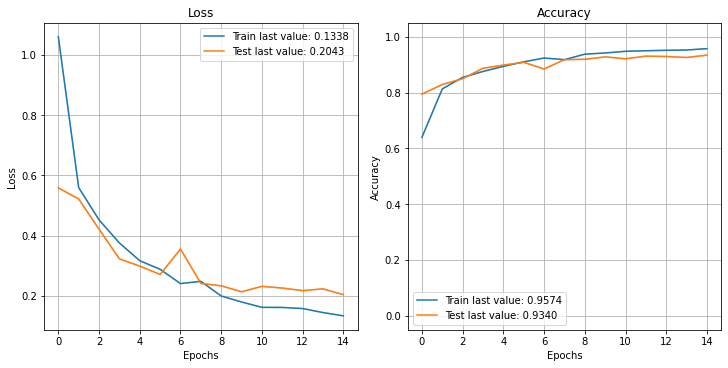

In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_out_dp = model_out_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=15,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_out_dp)

In [ ]:
print(hist_out_dp)

{'val_loss': [0.5590550621410996, 0.5219233335358548, 0.42171670585107246, 0.3230168779246765, 0.298957180547238, 0.27122777162740086, 0.3557931782368003, 0.24146330053139603, 0.2335448968076623, 0.21379302699592803, 0.2317688370214899, 0.22615001948014116, 0.21760430962617275, 0.22342706429624476, 0.20427180714242055], 'val_accuracy': [0.7946157455444336, 0.8289188146591187, 0.8497611880302429, 0.887103796005249, 0.8983933925628662, 0.908380389213562, 0.8844984769821167, 0.9179331064224243, 0.9192357659339905, 0.9279201030731201, 0.9209726452827454, 0.9305254220962524, 0.9292227625846863, 0.9257490038871765, 0.9339991211891174], 'loss': [1.0608016889070004, 0.5597848986207695, 0.4524763186724575, 0.37588522679655717, 0.31690146933996216, 0.28845062080075057, 0.24098466114499809, 0.24854423237776893, 0.19976295390967616, 0.17985450647448145, 0.1620017041670191, 0.1617622843441895, 0.15810611160179686, 0.14470480027600077, 0.13380908838165825], 'accuracy': [0.6395457, 0.8130702, 0.85458

In [ ]:
#Input Layer Dropout. 
###############################################################################
model_input_dp = Sequential()
model_input_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout, defined within the LSTM layer
model_input_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
model_input_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_input_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_input_dp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/10
5371/5371 [==============================] - 22s 4ms/step - loss: 1.0578 - accuracy: 0.6554 - val_loss: 0.6529 - val_accuracy: 0.7742
Epoch 2/10
5371/5371 [==============================] - 21s 4ms/step - loss: 0.6432 - accuracy: 0.7684 - val_loss: 0.5001 - val_accuracy: 0.8116
Epoch 3/10
5371/5371 [==============================] - 21s 4ms/step - loss: 0.5116 - accuracy: 0.8252 - val_loss: 0.3854 - val_accuracy: 0.8524
Epoch 4/10
5371/5371 [==============================] - 21s 4ms/step - loss: 0.4539 - accuracy: 0.8417 - val_loss: 0.3411 - val_accuracy: 0.8680
Epoch 5/10
5371/5371 [==============================] - 21s 4ms/step - loss: 0.4062 - accuracy: 0.8542 - val_loss: 0.3238 - val_accuracy: 0.8819
Epoch 6/10
5371/5371 [==============================] - 21s 4ms/step - loss: 0.3566 - accuracy: 0.8775 - val_loss: 0.2735 - val_accuracy: 0.9032
Epoch 7/10
5371/5371 [==============================] - 21s 4ms/step - lo

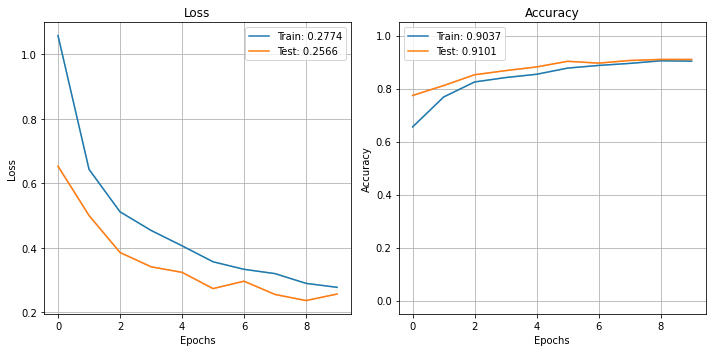

In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_input_dp = model_input_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_input_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_input_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_input_dp)

In [ ]:
#recurent_dropout
###############################################################################
model_rec_dp = Sequential()
model_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
model_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
model_rec_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_rec_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_rec_dp.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 20s 4ms/step - loss: 1.0228 - accuracy: 0.6513 - val_loss: 0.5503 - val_accuracy: 0.8020
Epoch 2/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.5728 - accuracy: 0.8064 - val_loss: 0.4457 - val_accuracy: 0.8524
Epoch 3/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.4511 - accuracy: 0.8527 - val_loss: 0.3711 - val_accuracy: 0.8736
Epoch 4/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.3647 - accuracy: 0.8743 - val_loss: 0.3284 - val_accuracy: 0.8836
Epoch 5/5
5371/5371 [==============================] - 9s 2ms/step
Training Accuracy: 0.9185
Testing Accuracy:  0.8962


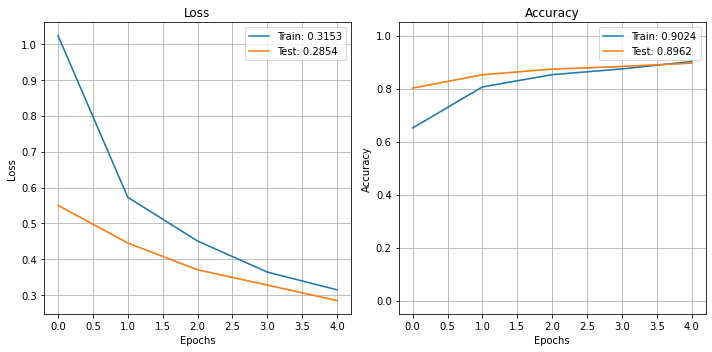

In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_rec_dp = model_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_rec_dp)

In [ ]:
#Combain all dropout
##############################################################################
model_all_dp = Sequential()
model_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
model_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
model_all_dp.add(Dropout(0.5))
model_all_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_all_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_all_dp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/12
5371/5371 [==============================] - 16s 3ms/step - loss: 1.2826 - accuracy: 0.5764 - val_loss: 0.8172 - val_accuracy: 0.7117
Epoch 2/12
5371/5371 [==============================] - 15s 3ms/step - loss: 0.8371 - accuracy: 0.7241 - val_loss: 0.6247 - val_accuracy: 0.7764
Epoch 3/12
5371/5371 [==============================] - 15s 3ms/step - loss: 0.7214 - accuracy: 0.7479 - val_loss: 0.5642 - val_accuracy: 0.8007
Epoch 4/12
5371/5371 [==============================] - 15s 3ms/step - loss: 0.6378 - accuracy: 0.7809 - val_loss: 0.4681 - val_accuracy: 0.8432
Epoch 5/12
5371/5371 [==============================] - 15s 3ms/step - loss: 0.5662 - accuracy: 0.8066 - val_loss: 0.4088 - val_accuracy: 0.8545
Epoch 6/12
5371/5371 [==============================] - 15s 3ms/step - loss: 0.5186 - accuracy: 0.8228 - val_loss: 0.3747 - val_accuracy: 0.8741
Epoch 7/12
5371/5371 [==============================] - 15s 3ms/step - lo

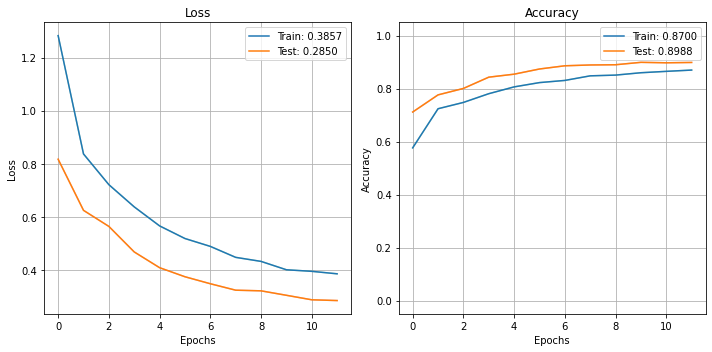

In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_all_dp = model_all_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=12,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_all_dp)

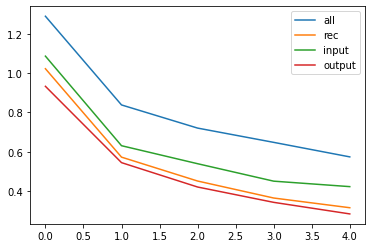

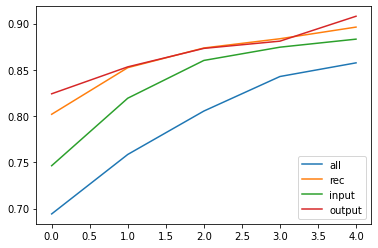

In [ ]:
#Compare all the models

plt.plot(hist_all_dp['loss'], label='all')
plt.plot(hist_rec_dp['loss'], label='rec')
plt.plot(hist_input_dp['loss'], label='input')
plt.plot(hist_out_dp['loss'], label='output')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist_all_dp['val_accuracy'], label='all')
plt.plot(hist_rec_dp['val_accuracy'], label='rec')
plt.plot(hist_input_dp['val_accuracy'], label='input')
plt.plot(hist_out_dp['val_accuracy'], label='output')
plt.legend(loc='lower right')
plt.show()
